In [1]:
from __future__ import division, print_function
import sys
import os
import glob
import re
import numpy as np
import base64

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Image processing libraries
from PIL import Image
import cv2

# Flask utilities
from flask import Flask, redirect, url_for, request, render_template, jsonify
from werkzeug.utils import secure_filename
from gevent.pywsgi import WSGIServer

# Keras utilities
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.utils import load_img, img_to_array
from keras.preprocessing import image
import tensorflow as tf
from keras import layers, ops
import keras


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [3]:
import os
# Function to get image file paths and corresponding labels
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for sub_dir in os.listdir(class_dir):
                sub_dir_path = os.path.join(class_dir, sub_dir)
                if os.path.isdir(sub_dir_path):
                    for img_name in os.listdir(sub_dir_path):
                        img_path = os.path.join(sub_dir_path, img_name)
                        if os.path.isfile(img_path):
                            img = cv2.imread(img_path)
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, (128, 128))
                            image_paths.append(img/255.0)
                            labels.append(label)
    
    return np.array(image_paths), labels, class_names

In [4]:
def load_original_images_and_labels(dataset_dir):
    image_paths, labels, class_names = get_image_paths_and_labels(dataset_dir)
    images = image_paths
    labels = np.array(labels)
    return images, labels, class_names

In [5]:
original_images, original_labels, class_names = load_original_images_and_labels(dataset)

In [6]:
MODEL_PATHS = {
    'resnet50': 'models/keras_best_model.keras',
    'resnet101': 'models/resnet_model.keras',
    'caries_GAN': 'models/caries_gan.h5',
    'caries_encoder': 'models/caries_encoder.h5',
    'caries_decoder': 'models/caries_decoder.h5',
    'gingivitis_GAN': 'models/gingivitis_gan.h5',
    'gingivitis_encoder': 'models/gingivitis_encoder.h5',
    'gingivitis_decoder': 'models/gingivitis_decoder.h5',
    'wsl_GAN': 'models/wsl_gan.h5',
    'wsl_encoder': 'models/wsl_encoder.h5',
    'wsl_decoder': 'models/wsl_decoder.h5',
}

In [7]:
# Load models
models = {
    'resnet50': load_model(MODEL_PATHS['resnet50']),
}

In [8]:
x = original_images[0]

In [9]:
x.shape

(128, 128, 3)

In [10]:
# Convert the image to a numpy array and expand dimensions to create a batch of size 1
x = np.expand_dims(x, axis=0)

In [11]:
x.shape

(1, 128, 128, 3)

In [12]:
# x = preprocess_input(x)

In [13]:
preds = models['resnet50'].predict(original_images)
labels = np.argmax(preds, axis=1)

I0000 00:00:1717323611.509332   85073 service.cc:145] XLA service 0x7cac2c015d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717323611.509353   85073 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
I0000 00:00:1717323612.440977   85117 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1686', 460 bytes spill stores, 348 bytes spill loads

I0000 00:00:1717323612.493225   85113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1679', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1717323612.605500   85120 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1686', 952 bytes spill stores, 620 bytes spill loads

I0000 00:00:1717323612.733068   85118 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory i

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1717323614.571501   85073 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [14]:
preds

array([[0.34266093, 0.28316304, 0.37417606],
       [0.35924333, 0.2718205 , 0.3689362 ],
       [0.36166176, 0.27241662, 0.36592162],
       [0.36692494, 0.2688673 , 0.36420777],
       [0.3646371 , 0.26488757, 0.37047535],
       [0.36104292, 0.2706561 , 0.36830094],
       [0.36742494, 0.26708338, 0.36549175],
       [0.3562144 , 0.27920595, 0.36457965],
       [0.36034006, 0.27051   , 0.36914992],
       [0.36384833, 0.27032617, 0.36582547],
       [0.34266093, 0.28316304, 0.37417606],
       [0.35924333, 0.2718205 , 0.3689362 ],
       [0.36166176, 0.27241662, 0.36592162],
       [0.35891458, 0.2708761 , 0.37020928],
       [0.36006725, 0.26754758, 0.37238514],
       [0.35648996, 0.27416098, 0.36934903],
       [0.34331918, 0.2766832 , 0.37999755],
       [0.36050373, 0.26852468, 0.37097165],
       [0.34266093, 0.28316304, 0.37417606],
       [0.35924333, 0.2718205 , 0.3689362 ],
       [0.36166176, 0.27241662, 0.36592162],
       [0.3615698 , 0.2716769 , 0.36675334],
       [0.

In [15]:
labels

array([2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2])

In [16]:
original_images.shape

(29, 128, 128, 3)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
# Print classification report
print(classification_report(original_labels, labels, target_names=class_names))

                   precision    recall  f1-score   support

           Caries       0.67      0.29      0.40         7
       Gingivitis       0.00      0.00      0.00        10
White Spot Lesion       0.42      0.92      0.58        12

         accuracy                           0.45        29
        macro avg       0.36      0.40      0.33        29
     weighted avg       0.34      0.45      0.34        29



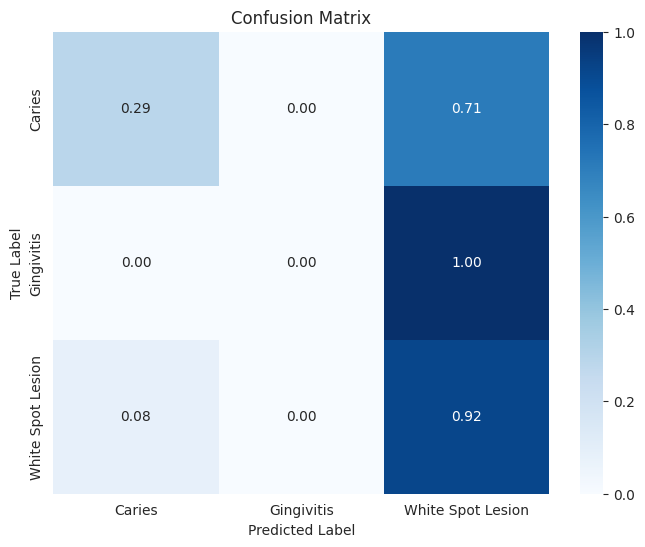

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate and plot confusion matrix
cm = confusion_matrix(original_labels, labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()